In [1]:
#uncomment this if you are not using puffer
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

#my container always require reinstalling these dependencies; uncomment this if you don't need to
!pip install -U spacy
!pip install torchtext
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are using ", device)

import numpy as np
import spacy

import random
import math
import time

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

     |████████████████████████████████| 6.1 MB 1.1 MB/s            
     |████████████████████████████████| 181 kB 11.8 MB/s            
     |████████████████████████████████| 128 kB 13.8 MB/s            
     |████████████████████████████████| 452 kB 13.2 MB/s            
     |████████████████████████████████| 42 kB 711 kB/s             
     |████████████████████████████████| 9.9 MB 11.7 MB/s            
     |████████████████████████████████| 635 kB 13.0 MB/s            
     |████████████████████████████████| 11.3 MB 787 kB/s             
     |████████████████████████████████| 58 kB 4.1 MB/s             
     |████████████████████████████████| 8.0 MB 1.2 MB/s            
     |████████████████████████████████| 881.9 MB 8.3 kB/s             
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0
    Uninstalling torch-1.10.0:
      Successfully uninstalled torch-1.10.0
     |████████████████████████████████| 13.9 MB 7.9 kB/s             
✔ Download and instal

# 2 - TorchText + GRU + Using Context Vector + Greedy Decoding 

In this second notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078). This model will achieve improved test perplexity whilst only using a single layer RNN in both the encoder and the decoder.  It also contains concept very similar to the attention mechanism but without softmax which we gonna introduce in tutorial 3.

This is edited from https://github.com/bentrevett.

### Introduction

Let's remind ourselves of the general encoder-decoder model.

![](assets/seq2seq1.png)

We use our encoder (green) over the embedded source sequence (yellow) to create a context vector (red). We then use that context vector with the decoder (blue) and a linear layer (purple) to generate the target sentence.

In the previous model, we used an multi-layered LSTM as the encoder and decoder.

![](assets/seq2seq4.png)

One downside of the previous model is that the decoder is trying to cram lots of information into the hidden states. Whilst decoding, the hidden state will need to contain information about the whole of the source sequence, as well as all of the tokens have been decoded so far. By alleviating some of this information compression, we can create a better model!

We'll also be using a GRU (Gated Recurrent Unit) instead of an LSTM (Long Short-Term Memory). Why? Mainly because that's what they did in the paper (this paper also introduced GRUs) and also because we used LSTMs last time. To understand how GRUs (and LSTMs) differ from standard RNNS, check out [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) link. Is a GRU better than an LSTM? [Research](https://arxiv.org/abs/1412.3555) has shown they're pretty much the same, and both are better than standard RNNs. 

## 1. Preprocessing

### Load the dataset

In [2]:
from torchtext.datasets import Multi30k

SRC_LANGUAGE = 'de'
TRG_LANGUAGE = 'en'
train_iter, valid_iter, test_iter = Multi30k(split=('train', 'valid', 'test'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

100%|██████████| 1.21M/1.21M [00:01<00:00, 651kB/s] 
100%|██████████| 46.3k/46.3k [00:00<00:00, 113kB/s] 
100%|██████████| 43.9k/43.9k [00:00<00:00, 110kB/s] 


In [3]:
len(train_iter)

29000

In [4]:
#let's try print one train sample
#a pair of src sentence (de) and target sentence (en)
sample = next(train_iter)
sample

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.\n',
 'Two young, White males are outside near many bushes.\n')

### Tokenizers

In [5]:
# Place-holders
token_transform = {}
vocab_transform = {}

Here is our two tokenizers:

In [6]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [7]:
#example of tokenization of the english part
print("English sentence: ", sample[1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

English sentence:  Two young, White males are outside near many bushes.

Tokenization:  ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '\n']


In [8]:
# helper function to yield list of tokens
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

In [9]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

In [10]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [11]:
#see some example
vocab_transform[TRG_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[2208, 11, 4, 0, 4]

In [12]:
len(vocab_transform[TRG_LANGUAGE])

6192

### Batch Iterator

In [13]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, trg_batch


In [14]:
from torchtext.data.functional import to_map_style_dataset

train_iter, valid_iter, test_iter = Multi30k(split=('train', 'valid', 'test'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

#if we simply use train_iter, once we run it, it cannot be iterate more, so let's convert to map style dataset
train_dataset = to_map_style_dataset(train_iter)
valid_dataset = to_map_style_dataset(valid_iter)
test_dataset = to_map_style_dataset(test_iter)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_fn)

In [15]:
src, trg = next(iter(train_loader))
print("src shape: ", src.shape) # (seq len, batch_size)
print("trg shape: ", trg.shape) # (seq len, batch_size)  #if you like batch size first, simply set batch_first = True

src shape:  torch.Size([25, 64])
trg shape:  torch.Size([26, 64])


## 2. Building the Seq2Seq Model

### Encoder

The encoder is similar to the previous one, with the multi-layer LSTM swapped for a single-layer GRU. We also don't pass the dropout as an argument to the GRU as that dropout is used between each layer of a multi-layered RNN. As we only have a single layer, PyTorch will display a warning if we try and use pass a dropout value to it.

Another thing to note about the GRU is that it only requires and returns a hidden state, there is no cell state like in the LSTM.

$$\begin{align*}
h_t &= \text{GRU}(e(x_t), h_{t-1})\\
(h_t, c_t) &= \text{LSTM}(e(x_t), h_{t-1}, c_{t-1})\\
h_t &= \text{RNN}(e(x_t), h_{t-1})
\end{align*}$$

From the equations above, it looks like the RNN and the GRU are identical. Inside the GRU, however, is a number of *gating mechanisms* that control the information flow in to and out of the hidden state (similar to an LSTM). Again, for more info, check out [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) excellent post. 

The rest of the encoder should be very familar from the last tutorial, it takes in a sequence, $X = \{x_1, x_2, ... , x_T\}$, passes it through the embedding layer, recurrently calculates hidden states, $H = \{h_1, h_2, ..., h_T\}$, and returns a context vector (the final hidden state), $z=h_T$.

$$h_t = \text{EncoderGRU}(e(x_t), h_{t-1})$$

This is identical to the encoder of the general seq2seq model, with all the "magic" happening inside the GRU (green).

![](assets/seq2seq5.png)

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim) #no dropout as only one layer!
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [seq len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        #embedded = [seq len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded) #no cell state!
        #outputs = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden

### Decoder

The decoder is where the implementation differs significantly from the previous model and we alleviate some of the information compression.

Instead of the GRU in the decoder taking just the embedded target token, $d(y_t)$ and the previous hidden state $s_{t-1}$ as inputs, it also takes the context vector $z$. 

$$s_t = \text{DecoderGRU}(d(y_t), s_{t-1}, z)$$

Note how this context vector, $z$, does not have a $t$ subscript, meaning we re-use the same context vector returned by the encoder for every time-step in the decoder. 

Before, we predicted the next token, $\hat{y}_{t+1}$, with the linear layer, $f$, only using the top-layer decoder hidden state at that time-step, $s_t$, as $\hat{y}_{t+1}=f(s_t^L)$. Now, we also pass the embedding of current token, $d(y_t)$ and the context vector, $z$ to the linear layer.

$$\hat{y}_{t+1} = f(d(y_t), s_t, z)$$

Thus, our decoder now looks something like this:

![](assets/seq2seq6.png)

Note, the initial hidden state, $s_0$, is still the context vector, $z$, so when generating the first token we are actually inputting two identical context vectors into the GRU.

How do these two changes reduce the information compression? Well, hypothetically the decoder hidden states, $s_t$, no longer need to contain information about the source sequence as it is always available as an input. Thus, it only needs to contain information about what tokens it has generated so far. The addition of $y_t$ to the linear layer also means this layer can directly see what the token is, without having to get this information from the hidden state. 

However, this hypothesis is just a hypothesis, it is impossible to determine how the model actually uses the information provided to it (don't listen to anyone that says differently). Nevertheless, it is a solid intuition and the results seem to indicate that this modifications are a good idea!

Within the implementation, we will pass $d(y_t)$ and $z$ to the GRU by concatenating them together, so the input dimensions to the GRU are now `emb_dim + hid_dim` (as context vector will be of size `hid_dim`). The linear layer will take $d(y_t), s_t$ and $z$ also by concatenating them together, hence the input dimensions are now `emb_dim + hid_dim*2`. We also don't pass a value of dropout to the GRU as it only uses a single layer.

`forward` now takes a `context` argument. Inside of `forward`, we concatenate $y_t$ and $z$ as `emb_con` before feeding to the GRU, and we concatenate $d(y_t)$, $s_t$ and $z$ together as `output` before feeding it through the linear layer to receive our predictions, $\hat{y}_{t+1}$.

In [17]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, context):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #context = [n layers * n directions, batch size, hid dim]
        
        #n layers and n directions in the decoder will both always be 1, therefore:
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
                
        emb_con = torch.cat((embedded, context), dim = 2)
        #emb_con = [1, batch size, emb dim + hid dim]
            
        output, hidden = self.rnn(emb_con, hidden)
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]

        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim = 1)        
        #output = [batch size, emb dim + hid dim * 2]
        
        prediction = self.fc_out(output)
        #prediction = [batch size, output dim]
        
        return prediction, hidden

### Seq2Seq Model

Putting the encoder and decoder together, we get:

![](assets/seq2seq7.png)

Again, in this implementation we need to ensure the hidden dimensions in both the encoder and the decoder are the same.

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive a `context` vector
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and the context vector, $z$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate (either the ground truth next token in the target sequence or the highest predicted next token)

In [18]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is the context
        context = self.encoder(src)
        
        #context also used as the initial hidden state of the decoder
        hidden = context
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, context)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

## 3. Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one. 

We initialise our encoder, decoder and seq2seq model (placing it on the GPU if we have one). As before, the embedding dimensions and the amount of dropout used can be different between the encoder and the decoder, but the hidden dimensions must remain the same.

In [19]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
ENC_EMB_DIM = 256  #follow the paper
DEC_EMB_DIM = 256  #follow the paper
HID_DIM = 512  #follow the paper
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

Next, we initialize our parameters. The paper states the parameters are initialized from a normal distribution with a mean of 0 and a standard deviation of 0.01, i.e. $\mathcal{N}(0, 0.01)$. 

It also states we should initialize the recurrent parameters to a special initialization, however to keep things simple we'll also initialize them to $\mathcal{N}(0, 0.01)$.

In [20]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8015, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6192, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=6192, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

We print out the number of parameters.

Even though we only have a single layer RNN for our encoder and decoder we actually have **more** parameters  than the last model. This is due to the increased size of the inputs to the GRU and the linear layer. However, it is not a significant amount of parameters and causes a minimal amount of increase in training time (~3 seconds per epoch extra).

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,720,816 trainable parameters


We initiaize our optimizer.

In [22]:
optimizer = optim.Adam(model.parameters())

We also initialize the loss function, making sure to ignore the loss on `<pad>` tokens.

In [23]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

We then create the training loop...

In [24]:
def train(model, loader, optimizer, criterion, clip):
    
    model.train()
    epoch_loss = 0
    
    for src, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [25]:
def evaluate(model, loader, criterion):
    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, trg in loader:
            
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

We'll also define the function that calculates how long an epoch takes.

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [27]:
N_EPOCHS = 10
CLIP = 1

train_losses = []
valid_losses = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 41s
	Train Loss: 4.819 | Train PPL: 123.798
	 Val. Loss: 4.985 |  Val. PPL: 146.165
Epoch: 02 | Time: 0m 38s
	Train Loss: 4.192 | Train PPL:  66.187
	 Val. Loss: 4.559 |  Val. PPL:  95.507
Epoch: 03 | Time: 0m 37s
	Train Loss: 3.724 | Train PPL:  41.416
	 Val. Loss: 4.158 |  Val. PPL:  63.943
Epoch: 04 | Time: 0m 35s
	Train Loss: 3.247 | Train PPL:  25.720
	 Val. Loss: 3.889 |  Val. PPL:  48.863
Epoch: 05 | Time: 0m 38s
	Train Loss: 2.873 | Train PPL:  17.688
	 Val. Loss: 3.756 |  Val. PPL:  42.757
Epoch: 06 | Time: 0m 35s
	Train Loss: 2.558 | Train PPL:  12.912
	 Val. Loss: 3.650 |  Val. PPL:  38.480
Epoch: 07 | Time: 0m 36s
	Train Loss: 2.287 | Train PPL:   9.850
	 Val. Loss: 3.674 |  Val. PPL:  39.406
Epoch: 08 | Time: 0m 39s
	Train Loss: 2.055 | Train PPL:   7.806
	 Val. Loss: 3.634 |  Val. PPL:  37.849
Epoch: 09 | Time: 0m 38s
	Train Loss: 1.879 | Train PPL:   6.550
	 Val. Loss: 3.679 |  Val. PPL:  39.624
Epoch: 10 | Time: 0m 35s
	Train Loss: 1.717 | Train PPL

Finally, we test the model on the test set using these "best" parameters.

In [28]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.611 | Test PPL:  37.002 |


Text(0, 0.5, 'loss')

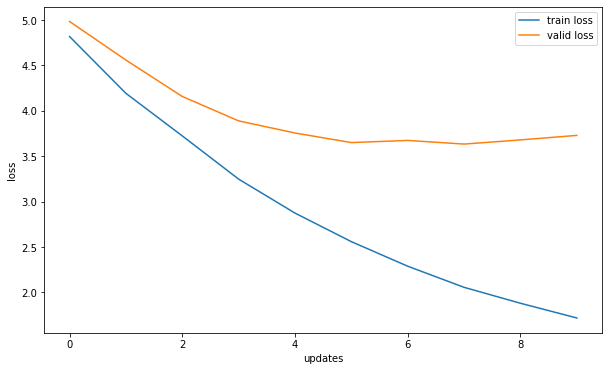

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Yay, looking at the test loss, this is a pretty good sign that this model architecture is doing something right!  Definitely I can try do some regularization (increasing the dropout) to reduce the overfitting but let's just move on to the next tutorial for the real attention mechanisms.